# Predict Pneumonia from x-ray scans
Made by
- Yannick K. Hartington

### Import Libraries

In [30]:
import datetime
import os
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import Sequential, models, utils
from keras.applications.imagenet_utils import (decode_predictions,
                                               preprocess_input)
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import (Activation, BatchNormalization, Conv2D, Dense,
                          Dropout, Flatten, Input, MaxPooling2D,
                          RandomBrightness, RandomFlip, RandomRotation, ReLU,
                          Rescaling)
from keras.preprocessing import image
from keras.utils import image_dataset_from_directory
from PIL import Image
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [2]:
tf.__version__

'2.15.0'

### Dataset
We will start out with inspecting the training set to see if it is proper balanced
#### Inspection of training set

In [3]:
dataset_path = r'/mnt/c/Datasets/Chest X-Ray Images/chest_xray' # WSL
#path_dataset = r'C:\Datasets\Chest X-Ray Images\chest_xray' # Windows

# Path to training dataset
train_path = os.path.join(dataset_path, 'train')

# Path to validation dataset
val_path = os.path.join(dataset_path, 'val')

# Path to test dataset
test_path = os.path.join(dataset_path, 'test')

In [4]:
normal_path = os.path.join(train_path, 'NORMAL')
pneumonia_path = os.path.join(train_path, 'PNEUMONIA')

normal_cases = [f for f in os.listdir(normal_path) if f.endswith('.jpeg')]
pneumonia_cases = [f for f in os.listdir(pneumonia_path) if f.endswith('.jpeg')]

In [5]:
training_cases = []
for img in normal_cases:
    training_cases.append((img, 0))

for img in pneumonia_cases:
    training_cases.append((img, 1))

We will take a quick look at how normal and pneumonia cases looks like in the training set

In [6]:
normal_images = random.sample(normal_cases,4)
pneumonia_images = random.sample(pneumonia_cases,4)

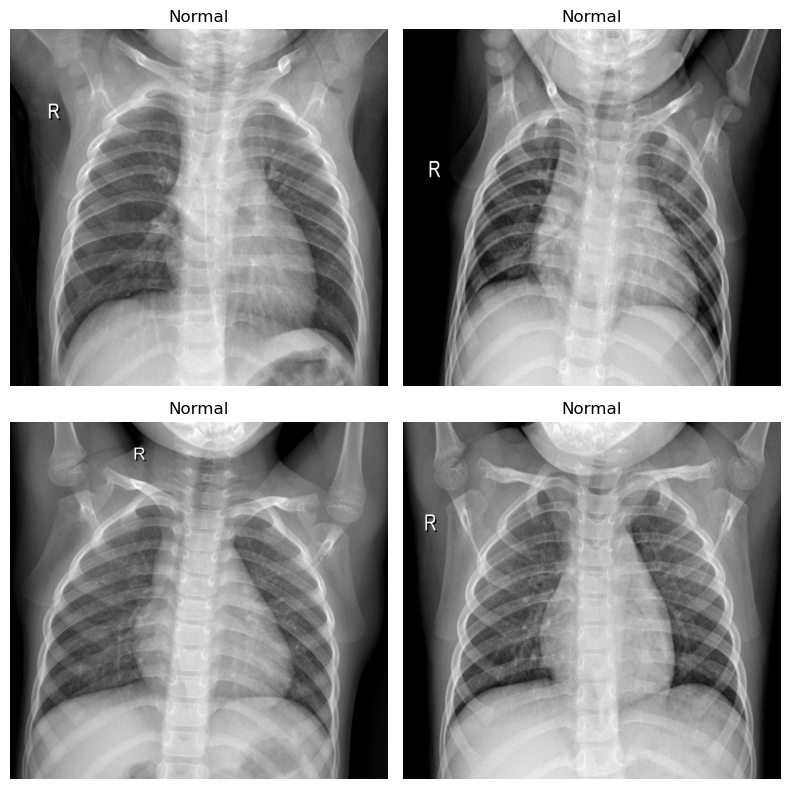

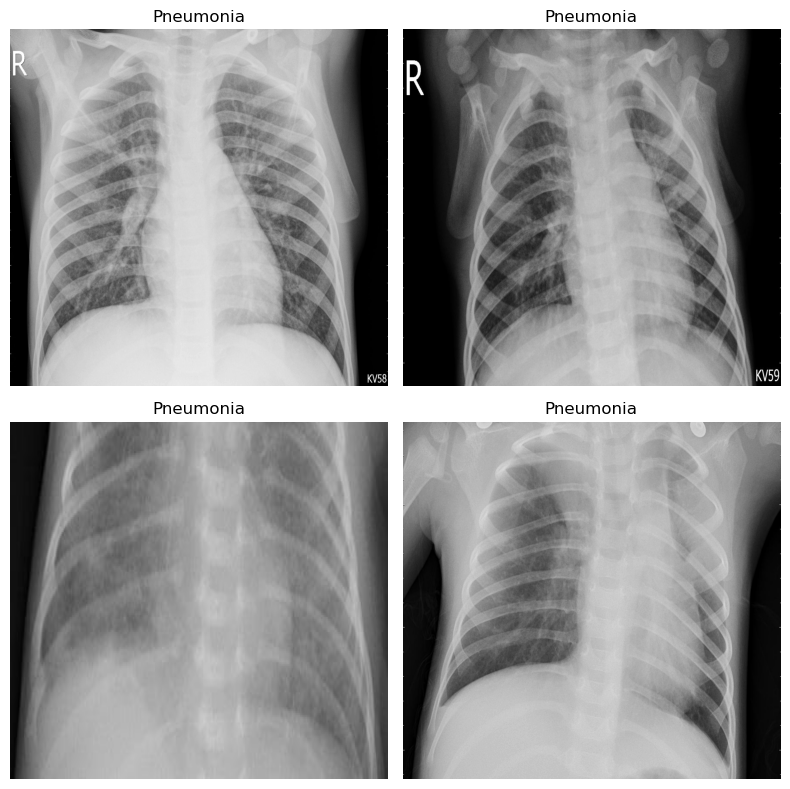

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i in range(4):
    img = Image.open(normal_path + '/' + normal_images[i])
    axes[i//2, i%2].imshow(img, cmap='gray')
    axes[i//2, i%2].set_title("Normal")
    axes[i//2, i%2].axis('off')
    axes[i//2, i%2].set_aspect('auto')

# Adjust layout to prevent overlapping
plt.tight_layout() 
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i in range(4):
    img = Image.open(pneumonia_path + '/' + pneumonia_images[i])
    axes[i//2, i%2].imshow(img, cmap='gray')
    axes[i//2, i%2].set_title("Pneumonia")
    axes[i//2, i%2].axis('off')
    axes[i//2, i%2].set_aspect('auto')

# Adjust layout to prevent overlapping
plt.tight_layout() 
plt.show()

Next we check the balance of the two categories in the training dataset

Label
1    3875
0    1341
Name: count, dtype: int64


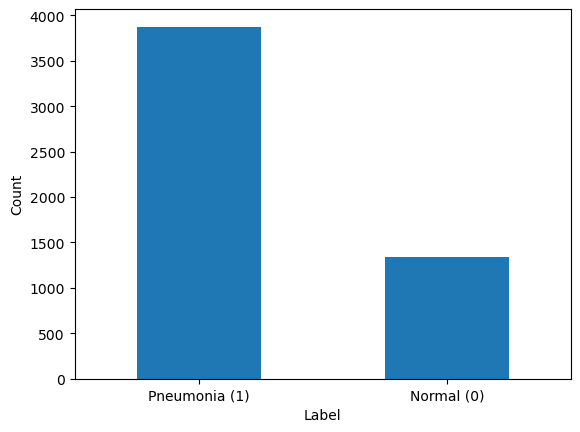

In [8]:
training_data = pd.DataFrame(training_cases, columns=['Image', 'Label'])
cases_count = training_data['Label'].value_counts()
ax = training_data['Label'].value_counts().plot(kind='bar', rot=0)
ax.set_xticks(range(len(cases_count.index)), ['Pneumonia (1)', 'Normal (0)'])
ax.set_ylabel('Count')
print(cases_count)

We can see that our training data is quite unbalanced, with almost 3 times as many Pneumonia cases compared to normal cases. In a perfect world we would just collect some more data(normal cases), however, this is not possible here. Instead we will utilize Data Augmentation, which will increase the size of the training data by taking the original samples and transform them in different ways. The Data Augmentation will take place in the first layers of the model.

#### Load datasets

In [9]:
batch_size = 32
DIM = 224
target_size = (DIM, DIM)
seed = 42

In [10]:
target_size 

(224, 224)

In [11]:
train_ds = image_dataset_from_directory(
  (dataset_path + '/train'),
  seed=123,
  image_size=target_size,
  batch_size=batch_size)

val_ds = image_dataset_from_directory(
  (dataset_path + '/val'),
  seed=123,
  image_size=target_size,
  batch_size=batch_size)

test_ds = image_dataset_from_directory(
  (dataset_path + '/test'),
  seed=123,
  image_size=target_size,
  batch_size=batch_size)

Found 5216 files belonging to 2 classes.


2024-02-21 12:31:45.452537: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 12:31:45.599997: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 12:31:45.600072: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 12:31:45.602767: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 12:31:45.602819: I external/local_xla/xla/stream_executor

Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model 
Here we create a simple CNN with some Data Augmentation layers. However, we will also use partial transfer learning, where we will set the weights for the first 3 conv2D-layers, with some that are pre-trained on ImageNet. The reason we are doing this, is because the first few layers are capturing low-level features, such as edges, colors, blobs, etc. So, instead of these weights are randomly initialized, we take some weights that are already capable of capturing these low-level features.

In [13]:
data_augmentation = Sequential([
    RandomBrightness(factor=[-0.1, 0.1], value_range=[0.0, 1.0]),
    RandomFlip(mode="horizontal"),
    RandomRotation(factor=(-0.1, 0.1))
], name='Data_augmentation')

model = Sequential([
    Input((DIM, DIM, 3)),
    Rescaling(1./255), # Pixel values are typically between 0 and 255. We would like to have them between 0 and 1
    data_augmentation,
    Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2d_1'),
    Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2d_2'), 
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Dropout(0.5),
    Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2d_3'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2,2)),

    Dropout(0.7),
    Conv2D(128, (1, 7), activation='relu'),
    Conv2D(128, (7, 1), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Dropout(0.5),
    Conv2D(256, (3, 3), activation='relu', padding='same', name='lastConv'),
    ReLU(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.7),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 Data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 128)     3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 128)     147584    
                                                                 
 batch_normalization (Batch  (None, 224, 224, 128)     512       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 128)     0

Throughout the training we utilize some callbacks:
- ModelCheckpoint: To save the best weights depending on a monitored metric. In our case the accuracy on the validation. dataset
- EarlyStopping: To stop training when the model stop to improve on the monitored metric for a number of epochs. Here we also restore the weights, which resulted in the best performence on the monitored metric.
- TensorBoard: To monitor the models progress while training.
 

In [14]:
monitor = 'val_accuracy'
checkpoint_filepath = r'./tmp/checkpoint'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor=monitor,
    mode='max',
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor=monitor, 
    patience=15, 
    restore_best_weights=True)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [model_checkpoint_callback, early_stopping, tensorboard_callback]

In [65]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy'])

history = model.fit(
    train_ds,
    batch_size=32, 
    epochs=100, 
    #verbose=2,
    validation_data = val_ds, 
    callbacks=callbacks
    )

Epoch 1/100


2024-02-13 16:33:47.244825: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


163/163 [==============================] - 46s 219ms/step - loss: 1.0498 - accuracy: 0.7281 - val_loss: 80.3809 - val_accuracy: 0.5000
Epoch 2/100
163/163 [==============================] - 34s 211ms/step - loss: 0.4617 - accuracy: 0.7479 - val_loss: 78.9220 - val_accuracy: 0.5000
Epoch 3/100
163/163 [==============================] - 34s 210ms/step - loss: 0.3925 - accuracy: 0.8071 - val_loss: 21.7462 - val_accuracy: 0.5000
Epoch 4/100
163/163 [==============================] - 34s 208ms/step - loss: 0.3491 - accuracy: 0.8497 - val_loss: 3.0898 - val_accuracy: 0.5000
Epoch 5/100
163/163 [==============================] - 34s 206ms/step - loss: 0.3322 - accuracy: 0.8574 - val_loss: 0.7213 - val_accuracy: 0.5000
Epoch 6/100
163/163 [==============================] - 33s 204ms/step - loss: 0.2539 - accuracy: 0.8909 - val_loss: 15.6863 - val_accuracy: 0.5000
Epoch 7/100
163/163 [==============================] - 33s 205ms/step - loss: 0.2082 - accuracy: 0.9195 - val_loss: 0.8547 - val_acc

We then load the best weights and save the model

In [23]:
# The best weights are loaded into the model
model.load_weights(checkpoint_filepath)

# Save our best model
model.save('ModelChestXRay.keras')

### History of the training
Even though we used TensorBoard to monitor the training, we also plot the history of the training for good measure.

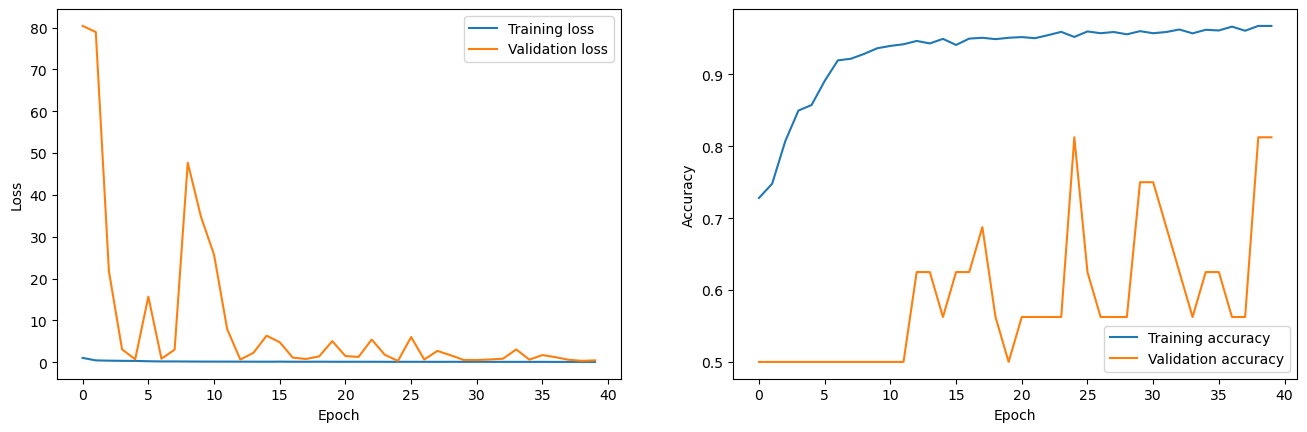

In [68]:
fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label='Training loss')
ax.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label='Training accuracy')
ax.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Evaluate model on the test set

In [69]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test set accuracy:", test_acc)

20/20 [==============================] - 2s 56ms/step - loss: 0.5048 - accuracy: 0.8237
Test set accuracy: 0.8237179517745972


### Evaluate model with the confusion matrix
Since our dataset is imbalanced the accuracy metric is not the best to judge our model from. For example, if our test set contained 85 pneumonia cases and 15 normal cases, and our model just predicted them all to have pneumonia, we would end up with a 85% accuracy. Instead we want to look at the Precision and Recall metrics.

In [70]:
# Collect all the labels from the test set
test_labels_true = []
for _, labels in test_ds:
    test_labels_true.append(labels.numpy())

test_labels_true = np.concatenate(test_labels_true, axis=0)

Now we use our model to predict the class on our test set. The predict fuction will return a predicted probability for the positive class, which in our case is pneumonia. I have chosen to use a threshold of 0.5, which means that if the model returns a probability of more than 50% that it is pneumonia, it will be classified as pneumonia. In real world cases more throught should be put into deciding this threshold.

In [71]:
test_labels_preds = model.predict(test_ds)
test_labels_preds = np.squeeze((test_labels_preds > 0.5).astype(np.int32), axis=1)

20/20 [==============================] - 2s 71ms/step


In [72]:
print(test_labels_true.shape)
print(test_labels_preds.shape)

(624,)
(624,)


We then create a confusion matrix.

Confusion Matrix:
[[134 100]
 [ 10 380]]


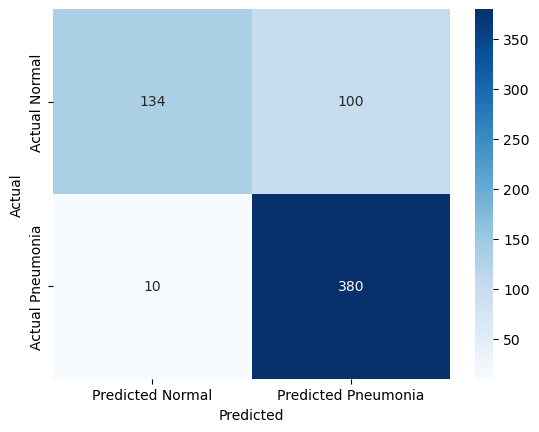

In [73]:
cm  = confusion_matrix(test_labels_true, test_labels_preds)
print("Confusion Matrix:")
print(cm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Normal', 'Predicted Pneumonia'], 
            yticklabels=['Actual Normal', 'Actual Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

We calculate the precision and recall metrics

In [74]:
recall = recall_score(test_labels_true, test_labels_preds)
precision = precision_score(test_labels_true, test_labels_preds)

print(f'The recall of the model is {round(recall, 2)}')
print((f'The precision of the model is {round(precision, 2)}'))

The recall of the model is 0.97
The precision of the model is 0.79


So, what does these two metrics mean in our case? 
- Recall tells us how many of all the pneumonia cases we actually predicted.
- Precision tells us how many of the predicted pneumonia cases actually was pneumonia cases. 

A thing to note is that there is a trade-off between the two metrics. This means that we can affect these metrics by changing the threshold for which class to predict.
- For example, lowering the threshold would increase the recall but decrease the presicion and vice versa.
- This could come in handy if we did't care how many cases we predicted as pneumonia, as long as we captured almost all of the pneumonia cases.